# Calculation of the the gradient in cylindrical coordinates using contravariant vector components

The strategy is to

* Calculate the vector in cartesian coordinates
* Transform them to a contravariantly cylindrical vector (transform the elements)

This way is chosen as the differential geometry package currently misses out the differential operations.
We will use a simple stupid approach, as that is what we need for these simple tasks

In [1]:
from collections import OrderedDict
from sympy import init_printing
from sympy import symbols, simplify, solve
from sympy import Eq
from sympy import exp, sqrt, atan, cos, sin
import re
from IPython.display import display

init_printing()

Define symbols

In [2]:
mu = symbols('mu', positive = True)
rho, rho0, z, z0 = symbols('rho, rho0, z, z0', positive = True)
theta, theta0 = symbols('theta, theta0', real = True)
x, y, z = symbols('x, y, z', real = True)
x0, y0, z0 = symbols('x0, y0, z0', real = True)
Ax, Ay, Az = symbols('A^x, A^y, A^z', real = True)
cart_symb = [x, y, z]
A_symb = [Ax, Ay, Az]

## Making a vector template

We will here make a "template" for the vectors, which we can use to replace components with.

Define our maps

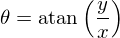

In [3]:
cylToCart = OrderedDict([(rho,sqrt(x**2+y**2)),
                         (theta, atan(y/x)),
                         (z, 1*z)])

for coord in cylToCart.keys():
    display(Eq(coord,cylToCart[coord]))

Unfortunately, the following gives unsatisfactory results (gives two solution where it should have been only one)

```python
# As z = z => True, we need to cast the coordinate to symbols(str())
eqs = tuple([Eq(symbols(str(coord)), cylToCart[coord]) for coord in cylToCart.keys()])
sol = solve(eqs, x, y, z)
display(sol)
```

Instead, the inverse map needs to be inserted manually

Manually insert the inverse transform

Normal transform

In [4]:
cartToCyl = OrderedDict([(x, rho*cos(theta)),
                         (y, rho*sin(theta)),
                         (z, z)])

for coord in cartToCyl.keys():
    display(Eq(coord,cartToCyl[coord]))

Transform for the $_0$ components

In [5]:
cartToCyl0 = OrderedDict([(x0, rho0*cos(theta0)),
                          (y0, rho0*sin(theta0)),
                          (z0, z0)])

for coord in cartToCyl0.keys():
    display(Eq(coord,cartToCyl0[coord]))

A contravariant vector transforms as

$$
(A')^i=\frac{\partial(x')^i}{\partial x^j}A^j
$$

where the prime $'$ refers to quantities with in the new coordinate system.

This gives us

Contravariant components written in cartesian coordinates

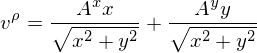

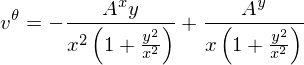

In [6]:
cylTemplateCart = OrderedDict.fromkeys(cylToCart)
for coord in cylTemplateCart.keys():
    cylTemplateCart[coord]  = 0
    for cart, A in zip(cart_symb, A_symb):
        cylTemplateCart[coord]  += A*cylToCart[coord].diff(cart)
    display(Eq(symbols('v^'+str(coord)),cylTemplateCart[coord]))

Contravariant components written in cylindrical coordinates

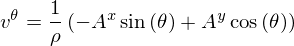

In [7]:
cylTemplateCyl = cylTemplateCart.copy()
replace = [(coord, cartToCyl[coord]) for coord in cartToCyl.keys()]
for coord in cylTemplateCyl.keys():
    cylTemplateCyl[coord] = simplify(cylTemplateCyl[coord].subs(replace))
    display(Eq(symbols('v^'+str(coord)),cylTemplateCyl[coord]))

## Gradient of the function

We will here take the cartesian gradient of a function, which we will use to generate our vector.

Define our function to take the gradient of (in cartesian coordinates)

In [8]:
f = exp(-((x - x0)**2 + (y - y0)**2 + (z-z0)**2)/mu**2)
display(Eq(symbols('f'), f))

We now calculate the divergence in cartesian coordinates

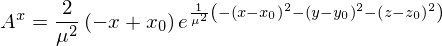

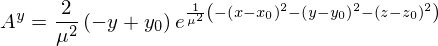

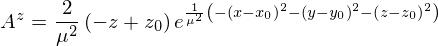

In [9]:
cartVec = OrderedDict([(x, simplify(f.diff(x))),
                       (y, simplify(f.diff(y))),
                       (z, simplify(f.diff(z)))])

for coord in cartVec.keys():
    display(Eq(symbols('A^' + str(coord)),cartVec[coord]))

## Transform to cylindrical coordinates

Now we write this in cylindrical coordinates

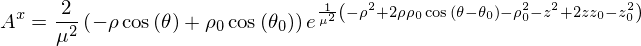

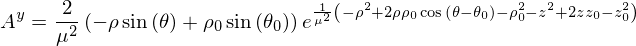

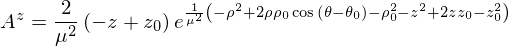

In [10]:
replace =  [(coord, cartToCyl[coord]) for coord in cartToCyl.keys()]
replace0 = [(coord, cartToCyl0[coord]) for coord in cartToCyl0.keys()]
cartVecCyl = cartVec.copy()
for coord in cartVec.keys():
    cartVecCyl[coord] = cartVecCyl[coord].subs(replace)
    cartVecCyl[coord] = simplify(cartVecCyl[coord].subs(replace0))
    display(Eq(symbols('A^'+str(coord)),cartVecCyl[coord]))

We now insert $A^i$ in the $v^j$ components

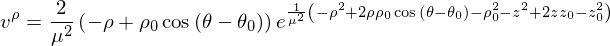

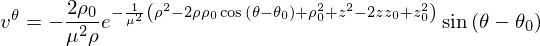

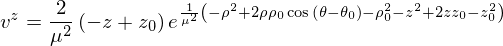

In [11]:
# Appendable list
replace = []
coords = cartVecCyl.keys()
for A, coord in zip(A_symb, coords):
    replace.append((A, cartVecCyl[coord]))

replace = tuple(replace)
cylVec = cylTemplateCyl.copy()
for coord in cylVec.keys():
    cylVec[coord] = simplify(cylVec[coord].subs(replace))
    display(Eq(symbols('v^'+str(coord)),cylVec[coord]))

## Paste to BOUT++

We would like to be able to copy paste the above directly into BOUT++

In [12]:
def BOUTstring(string, cylindrical=False):
    outstring = string.replace('**', '^')
    
    replacements = [('mu', 'cst:mu'),
                    ('rho', 'geom:xl'),
                    ('theta', 'z'),
                    ('x', 'geom:xl'),
                    ('y', 'geom:yl'),
                    ('rho0', 'cst:rho0'),
                    ('theta0', 'cst:theta0'),
                    ('x0', 'cst:x0'),
                    ('y0', 'cst:y0'),
                    ('z0', 'cst:z0'),
                   ]
    
    if cylindrical:
        # Insert this in the front, so that we don't first replace theta to z, then z to geom:yl
        replacements.insert(0, ('z', 'geom:yl'))
    
    for replacement in replacements:
        outstring = re.sub(r'\b'+replacement[0]+r'\b', replacement[1], outstring)
        
    return outstring

Print the BOUT++ strings

In [13]:
for coord in cylVec.keys():
    print("{0}_contravariant = {1}".format(coord, BOUTstring(str(cylVec[coord]), cylindrical=True)) + "\n"*2)
    
for coord in cartVec.keys():
    print("{0} = {1}".format(coord, BOUTstring(str(cartVec[coord]))) + "\n"*2)

rho_contravariant = 2*(-geom:xl + cst:rho0*cos(z - cst:theta0))*exp((-geom:xl^2 + 2*geom:xl*cst:rho0*cos(z - cst:theta0) - cst:rho0^2 - geom:yl^2 + 2*geom:yl*cst:z0 - cst:z0^2)/cst:mu^2)/cst:mu^2


theta_contravariant = -2*cst:rho0*exp(-(geom:xl^2 - 2*geom:xl*cst:rho0*cos(z - cst:theta0) + cst:rho0^2 + geom:yl^2 - 2*geom:yl*cst:z0 + cst:z0^2)/cst:mu^2)*sin(z - cst:theta0)/(cst:mu^2*geom:xl)


z_contravariant = 2*(-geom:yl + cst:z0)*exp((-geom:xl^2 + 2*geom:xl*cst:rho0*cos(z - cst:theta0) - cst:rho0^2 - geom:yl^2 + 2*geom:yl*cst:z0 - cst:z0^2)/cst:mu^2)/cst:mu^2


x = 2*(-geom:xl + cst:x0)*exp((-(geom:xl - cst:x0)^2 - (geom:yl - cst:y0)^2 - (z - cst:z0)^2)/cst:mu^2)/cst:mu^2


y = 2*(-geom:yl + cst:y0)*exp((-(geom:xl - cst:x0)^2 - (geom:yl - cst:y0)^2 - (z - cst:z0)^2)/cst:mu^2)/cst:mu^2


z = 2*(-z + cst:z0)*exp((-(geom:xl - cst:x0)^2 - (geom:yl - cst:y0)^2 - (z - cst:z0)^2)/cst:mu^2)/cst:mu^2


